In [1]:
import dicom
import os
import pandas as pd
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

data_dir = 'D:/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('D:/stage1_labels.csv', index_col=0)
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

195 1
(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.321555830121981826540353244716
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 0000) Group Length                        UL: 390
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667399603379702974102486079290552633235
(0020, 000e) Series Instance UID     

In [25]:
for patient in patients[-100:]:
    label=labels_df.get_value(patient,'cancer')
    path=data_dir+patient
    slices=[dicom.read_file(path+'/'+s)for s in os.listdir(path)]
    slices.sort(key=lambda x:int(x.ImagePositionPatient[2]))
    print(len(slices),slices[0].pixel_array.shape)

173 (512, 512)
208 (512, 512)
151 (512, 512)
149 (512, 512)
143 (512, 512)
249 (512, 512)
180 (512, 512)
152 (512, 512)
142 (512, 512)
130 (512, 512)
340 (512, 512)
232 (512, 512)
140 (512, 512)
163 (512, 512)
179 (512, 512)
192 (512, 512)
212 (512, 512)
160 (512, 512)
176 (512, 512)
170 (512, 512)
160 (512, 512)
131 (512, 512)
206 (512, 512)
282 (512, 512)
209 (512, 512)
114 (512, 512)
132 (512, 512)
114 (512, 512)
153 (512, 512)
278 (512, 512)
240 (512, 512)
123 (512, 512)
199 (512, 512)
385 (512, 512)
180 (512, 512)
296 (512, 512)
175 (512, 512)
266 (512, 512)
191 (512, 512)
151 (512, 512)
300 (512, 512)
124 (512, 512)
129 (512, 512)
216 (512, 512)
164 (512, 512)
112 (512, 512)
160 (512, 512)
220 (512, 512)
160 (512, 512)
114 (512, 512)
160 (512, 512)
165 (512, 512)
241 (512, 512)
108 (512, 512)
130 (512, 512)
161 (512, 512)
156 (512, 512)
165 (512, 512)
146 (512, 512)
132 (512, 512)
139 (512, 512)
180 (512, 512)
328 (512, 512)
177 (512, 512)
176 (512, 512)
171 (512, 512)
132 (512, 

In [2]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

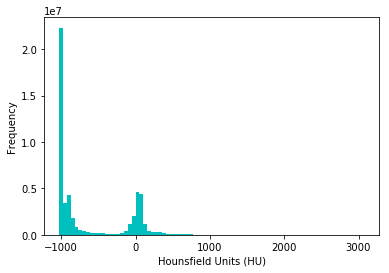

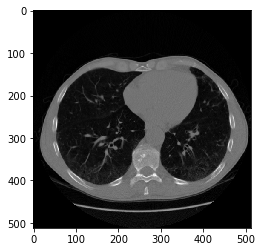

In [3]:
first_patient = load_scan(data_dir + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [4]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (195, 512, 512)
Shape after resampling	 (390, 355, 355)


In [21]:
def plot_3d(image, threshold=-300):
    
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

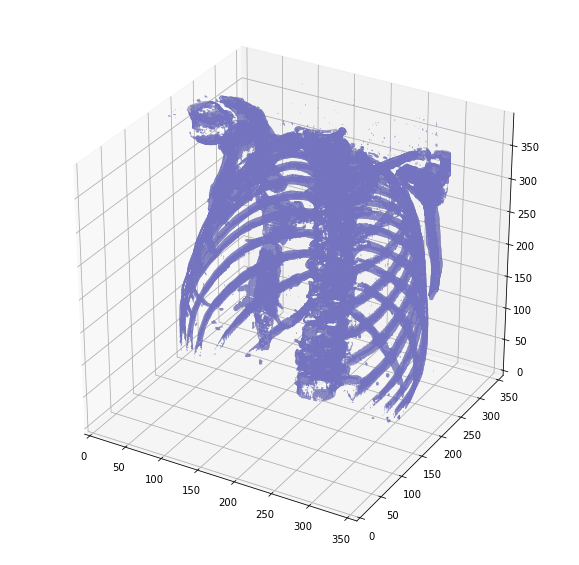

In [27]:
plot_3d(pix_resampled, 400)

In [22]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
    binary_image[background_label == labels] = 2
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [23]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

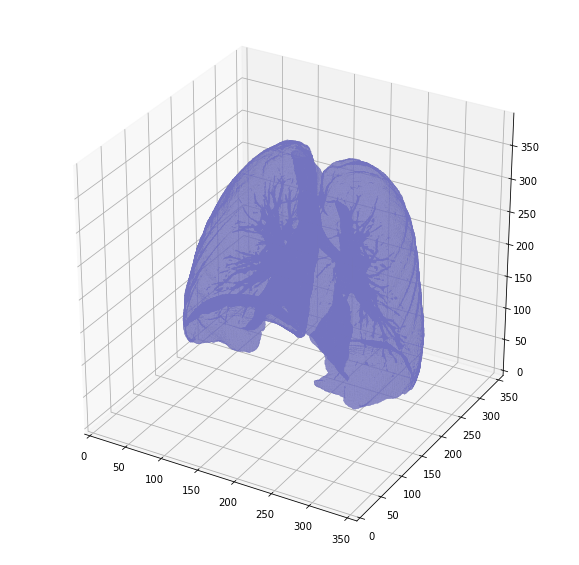

In [24]:
plot_3d(segmented_lungs, 0)

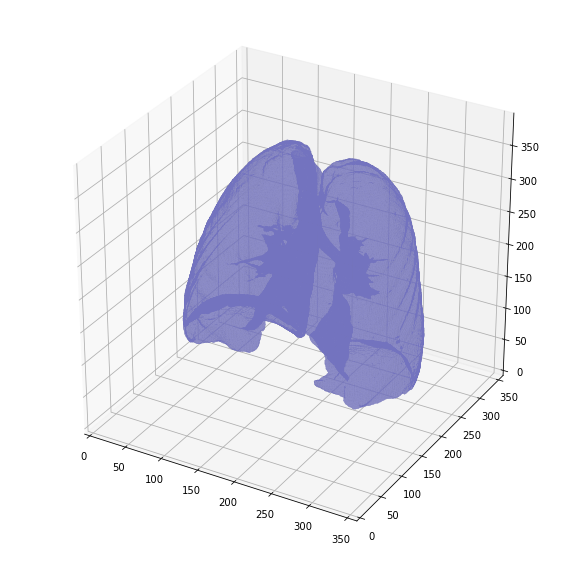

In [25]:
plot_3d(segmented_lungs_fill, 0)

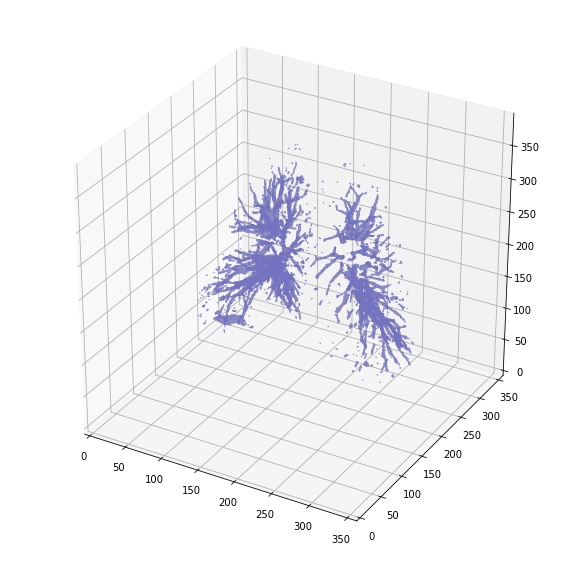

In [26]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

IM_PX_SIZE=50
HM_SLICES=20


def chunks(l,n):
    for i in range(0,len(l),n):
        yield l[i:i+n]
        
def mean(l):
    return sum(l)/len(l)

def process_data(patient,labels_df,img_px_size=50,hm_slices=20,visualize=False):
    label=labels_df.get_value(patient,'cancer')
    path=data_dir+patient
    slices=[dicom.read_file(path+'/'+s)for s in os.listdir(path)]
    slices.sort(key=lambda x:int(x.ImagePositionPatient[2]))
    
    new_slices=[]
    slices=[cv2.resize(np.array(each_slice.pixel_array),(IM_PX_SIZE,IM_PX_SIZE)) for each_slice in slices]
    chunk_sizes=math.ceil(len(slices)/HM_SLICES)
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk=list(map(mean,zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    if(len(new_slices)==HM_SLICES-1):
        new_slices.append(new_slices[-1])
    if(len(new_slices)==HM_SLICES-2):
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
    if(len(new_slices)==HM_SLICES-3):
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-2],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    print(len(new_slices))
    if visualize:
        fig=plt.figure()
        for num,each_slice in enumerate(new_slices):
            y=fig.add_subplot(4,5,num+1)
            y.imshow(each_slice)
        plt.show()
    if label==1:label=np.array([0,1])
    elif(label==0):label=np.array([1,0])
    
    return np.array(new_slices),label
much_data=[]
for num,patient in enumerate(patients):
    if num%100==0:
        print(num)
    try:
        img_data,label=process_data(patient,labels_df,img_px_size=IM_PX_SIZE,hm_slices=HM_SLICES)
        much_data.append([img_data,label])
    except KeyError as e:
        print("this is unlabeled data")
np.save('D:/predata-{}-{}-{}.npy'.format(IM_PX_SIZE,IM_PX_SIZE,HM_SLICES),much_data)

0
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
